# Cutout data from fits files

## Imports

In [1]:
import sys
import os
import pprint
import json
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

root = "/Users/phdenzel/gleam"
sys.path.append(root)
import gleam
from gleam.lensobject import LensObject
from gleam.multilens import MultiLens
from gleam.utils.plotting import IPColorbar, IPPointCache
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()

## Main

### Search for a fits file

In [2]:
fidx = 5
files = !ls data/*/*[0-9]_field.fits
pprint.pprint(files)
filename = files[fidx]
lensname = os.path.basename(filename).split('.')[0]
print("Selected file: {}".format(lensname))

['data/SDSSJ0029-0055/SDSSJ0029-0055_field.fits',
 'data/SDSSJ0737+3216/SDSSJ0737+3216_field.fits',
 'data/SDSSJ0753+3416/SDSSJ0753+3426_field.fits',
 'data/SDSSJ0956+5100/SDSSJ0956+5100_field.fits',
 'data/SDSSJ1051+4439/SDSSJ1051+4439_field.fits',
 'data/SDSSJ1430+6104/SDSSJ1430+6104_field.fits',
 'data/SDSSJ1627-0053/SDSSJ1627-0053_field.fits']
Selected file: SDSSJ1430+6104_field


### Read fits file and extract data

In [3]:
hdu = fits.open(filename)
for h in hdu:
    if isinstance(h, fits.hdu.image.ImageHDU):
        hdu = h
        break
if isinstance(hdu, list):
    hdu = hdu[0]
print(hdu)
print(hdu.data.shape)
print(repr(hdu.header))

position = [p//2 for p in hdu.data.shape]

(5549, 5561)
XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5561                                                  
NAXIS2  =                 5549                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'        / Units of science product                       
                                                                                
CD1_1   = -1.38

In [4]:
lo = LensObject(filename, auto=False, glscfactory_options={})
print(lo.__v__)

Properties of that field are unknown [None]
filename            	SDSSJ1430+6104_field.fits
filepath            	/Users/phdenzel/slacs-match/data/SDSSJ1430+6104/SDSSJ1430+6104_field.fits
band                	
naxis1              	5561
naxis2              	5549
naxis_plus          	None
refval              	[217.6716562743603, 61.07480616674623]
refpx               	[2780.999999999822, 2774.999999999823]
center              	<217.6717, 61.0748>
px2deg              	[1.3888888888888002e-05, 1.38888888888896e-05]
px2arcsec           	[0.049999999999996804, 0.050000000000002556]
megacam_range       	None
field               	None
photzp              	None
mag_formula         	<function mag_formula at 0x115e6b320>
roi                 	ROISelector(5549, 5561)
lens                	None
srcimgs             	[]
zl                  	0.5
zs                  	3.0
mapr                	None
tdelay              	None
tderr               	None
light_model         	{}
stel_mass           	None
glscfacto

### Plot the data

<IPython.core.display.Javascript object>


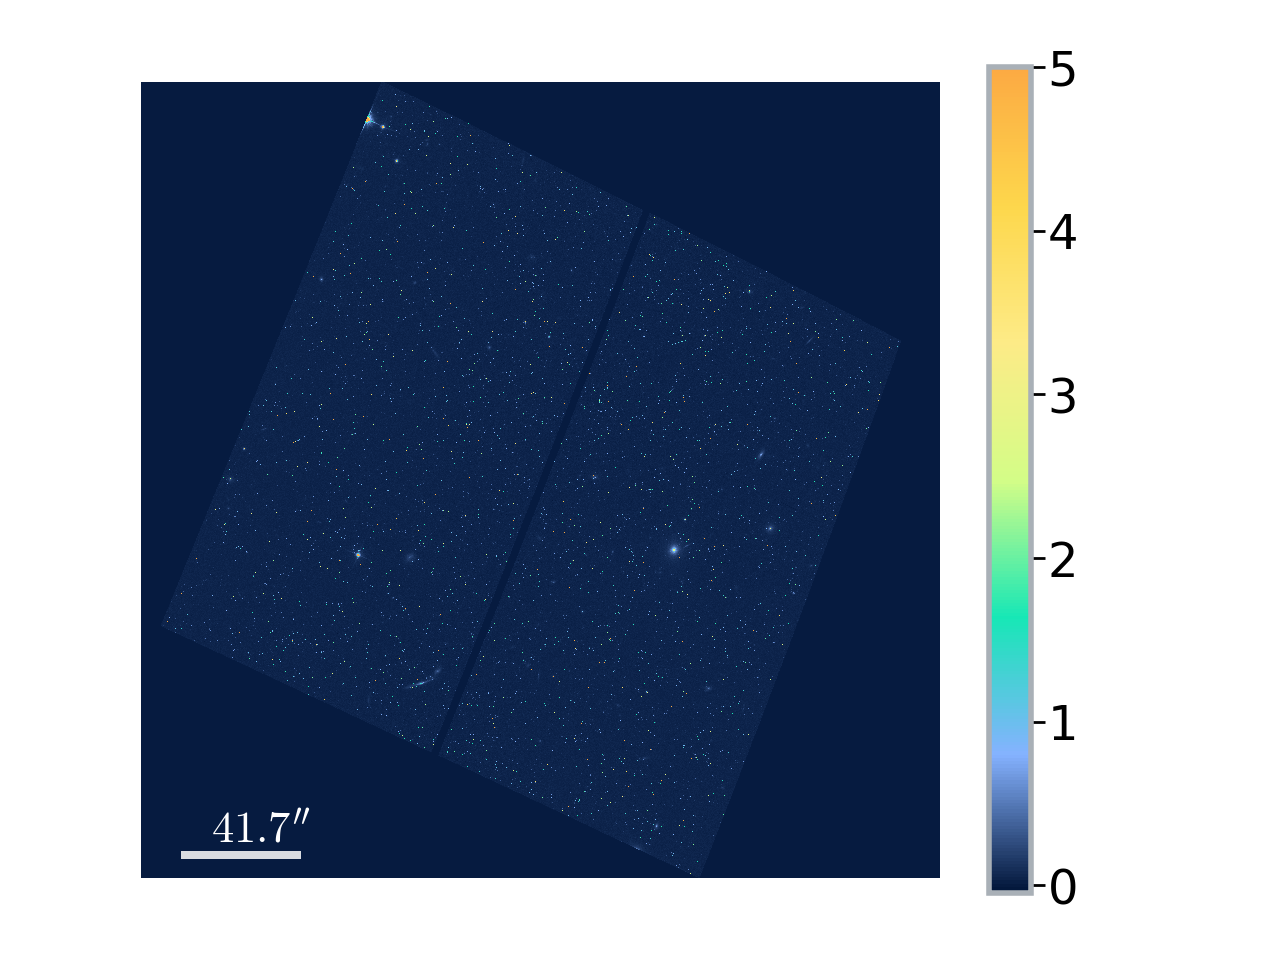

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2xvcm1hcCcsIGluZGV4PTE4NiwgbGF5b3V0PUxheW91dCh3aWR0aD11JzEwMCUnKSwgb3B0aW9ucz0odSdBY2NlbnQnLCDigKY=


Textarea(value=u'', description=u'Points', layout=Layout(height=u'200px', width=u'75%'), placeholder=u'Cache')

In [5]:
%matplotlib notebook

fig, ax = plt.subplots()
fig, ax, plt_out = lo.plot_f(fig, ax=ax, cmap=gcl.GLEAMcmaps.vilux, colorbar=True,
                             vmin=0, vmax=0.5*np.max(lo.data), source_images=False,
                             deconv=False, psf=np.ones((3, 3))/25.)
clrbar = IPColorbar(plt_out[1], plt_out[0])
clrbar.connect()
cache = IPPointCache(plt_out[0], use_modes=[])
cid = cache.connect()

In [6]:
if cache.xy:
    position = cache.xy[-1]
else:
    position = None
# plt.close()
print("Cutout center @ {}".format(position))

Cutout center @ [3709.503923214869, 2284.129510524318]


In [7]:
fs = fig.axes[0].viewLim
delta = int(0.5 + max(abs(fs.x1-fs.x0), abs(fs.y1-fs.y0)))
delta = int(np.ceil(delta / 99.0)) * 99
size = (delta, delta) if delta < hdu.data.shape[0] else hdu.data.shape
if size == hdu.data.shape:
    position = tuple(s//2 for s in hdu.data.shape)
print("position: {}".format(position), "size: {}".format(size))

('position: [3709.503923214869, 2284.129510524318]', 'size: (198, 198)')


### Ovewrite fits file and plot again

In [8]:
wcs = WCS(hdu.header)
cutout = Cutout2D(hdu.data, position, size, wcs)
hdu.data = cutout.data
hdu.header.update(cutout.wcs.to_header())

<IPython.core.display.Javascript object>


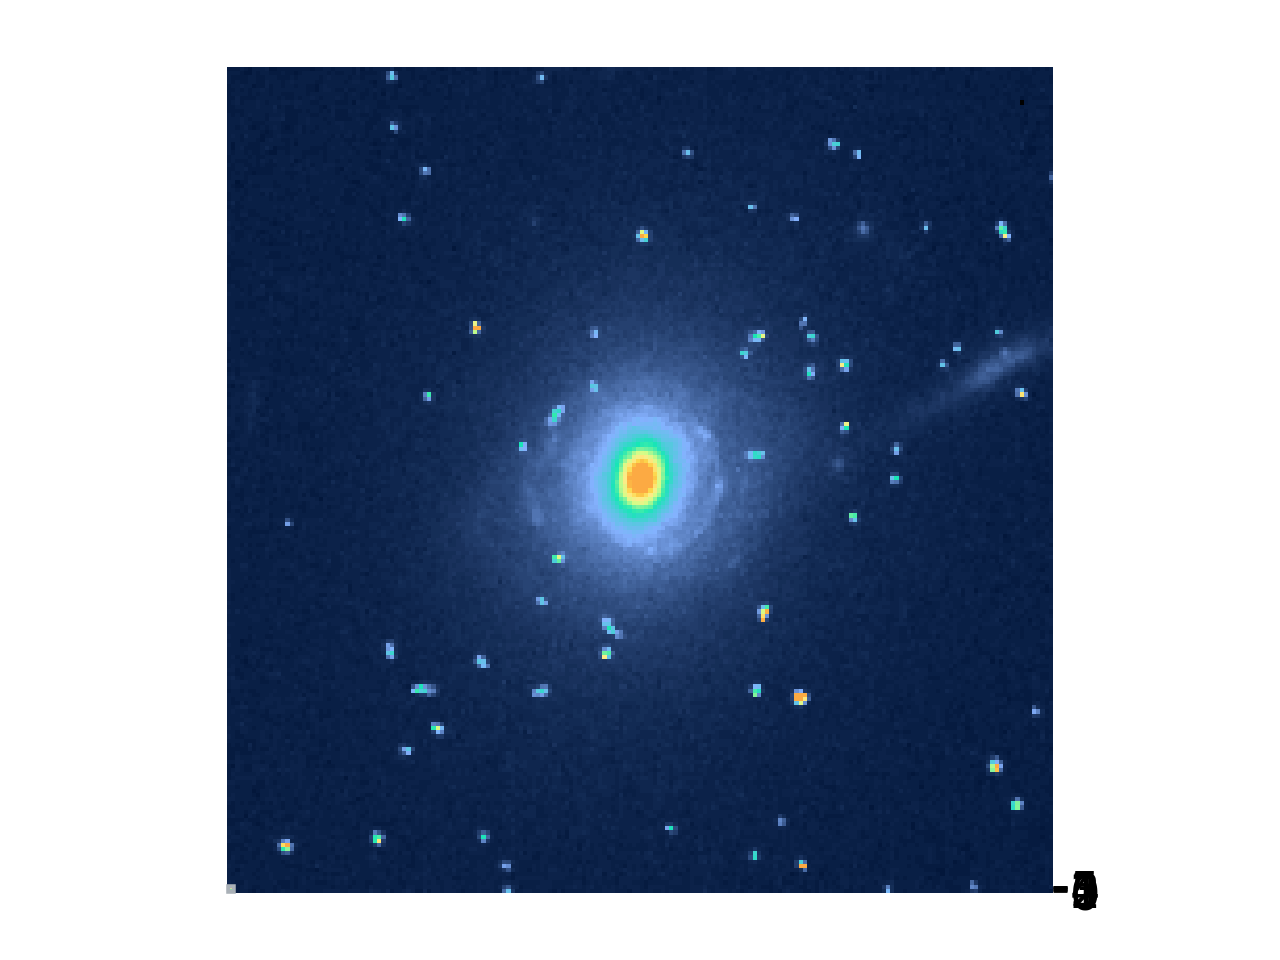

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2xvcm1hcCcsIGluZGV4PTE4NiwgbGF5b3V0PUxheW91dCh3aWR0aD11JzEwMCUnKSwgb3B0aW9ucz0odSdBY2NlbnQnLCDigKY=


In [9]:
# show again for validation
%matplotlib notebook

fig, ax = plt.subplots()
pltdta = hdu.data[:]
# pltdta = np.log10(pltdta+1+np.abs(np.nanmin(pltdta)))
plt_out = ax.imshow(pltdta, cmap=gcl.GLEAMcmaps.vilux, vmin=0, vmax=0.5*np.max(pltdta))
cbar = plt.colorbar(plt_out, cax=ax)
clrbar = IPColorbar(cbar, plt_out)
clrbar.connect()

### Save file

In [10]:
savename = "{}.fits".format(os.path.dirname(filename.replace('_field', '')))
print("Saving {}...".format(savename))

Saving data/SDSSJ1430+6104.fits...


In [ ]:
hdu.writeto(savename, overwrite=True)